# Definition

## Project Overview

## Problem Statement

## Metrics

# Analysis

## Data Exploration

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import pixiedust


%matplotlib inline

import plot_helper

Pixiedust database opened successfully


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The data set for this project was downloaded from Kaggle at  
[8anu climbing logbook](https://www.kaggle.com/dcohen21/8anu-climbing-logbook)

In [3]:
# Connect to db
conn = sqlite3.connect('data/8anu.sqlite')

# Read data into pandas
sql = ('SELECT a.id, a.country AS crag_country, a.crag_id, a.crag, a.sector_id, a.sector, a.name AS route, '
       'a.grade_id, g.fra_routes AS grade, a.year, a.date, a.method_id, m.shorthand AS method, a.notes, a.raw_notes, a.rating, '
       'a.user_id, u.country AS user_country, u.city AS user_city, u.sex, u.height, u.weight, u.birth AS birthdate, u.started AS started_climbing '
       'FROM ('
           'SELECT * '
           'FROM ascent '
           'WHERE crag=\'Frankenjura\' AND climb_type=0'
       ') AS a '
       'LEFT OUTER JOIN grade AS g ON a.grade_id=g.id '
       'LEFT OUTER JOIN method AS m ON a.method_id=m.id '
       'LEFT OUTER JOIN user AS u ON a.user_id=u.id '
       )
df = pd.read_sql_query(sql, conn)

# Close db connection
conn.close()

In [4]:
# Export to .csv for submitting Project Proposal to Udacity
#df.to_csv('data/8anu_franken.csv', sep=';')

In [5]:
# Export to .xlsx
# Create a Pandas Excel writer using XlsxWriter as the engine.
#writer = pd.ExcelWriter('data/8anu_franken.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
#df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
#writer.save()

### General information about the data set

In [6]:
## Get a list of all columns
df.columns

Index(['id', 'crag_country', 'crag_id', 'crag', 'sector_id', 'sector', 'route',
       'grade_id', 'grade', 'year', 'date', 'method_id', 'method', 'notes',
       'raw_notes', 'rating', 'user_id', 'user_country', 'user_city', 'sex',
       'height', 'weight', 'birthdate', 'started_climbing'],
      dtype='object')

In [7]:
df.head(5)

,id,crag_country,crag_id,crag,sector_id,sector,route,grade_id,grade,year,...,raw_notes,rating,user_id,user_country,user_city,sex,height,weight,birthdate,started_climbing
0,582,DEU,16600,Frankenjura,126,Grüne Hölle,Isolation,46,6c+,2000,...,0,0,39,NLD,Eindhoven,0.0,178.0,78.0,1972-10-16,1996.0
1,805,DEU,16600,Frankenjura,111,Marientaler Wände,Kraftfeld,59,7c+,1999,...,0,0,32,SWE,Gothenburg,0.0,174.0,0.0,1976-06-15,1996.0
2,902,DEU,16600,Frankenjura,1309,Obere Schlossbergwände,Ursus,49,7a,2000,...,0,0,49,SWE,GÖTEBORG,0.0,0.0,0.0,None,1990.0
3,903,DEU,16600,Frankenjura,0,,Don't know name,46,6c+,2000,...,0,0,49,SWE,GÖTEBORG,0.0,0.0,0.0,None,1990.0
4,935,DEU,16600,Frankenjura,422,Richard Wagner Fels,Fight Gravity,53,7b,1999,...,0,0,3,SWE,Umeå,0.0,180.0,78.0,1973-09-09,1995.0


In [8]:
records_count = df.shape[0]
ratings_count = df[ df['rating'] == 0].shape[0]


f'There are {records_count:,} data entries in our dataset.'
f'{ratings_count:,} out of these contain a rating. That is approx. {ratings_count / records_count * 100:.2f}%'

'There are 114,589 data entries in our dataset.'

'60,303 out of these contain a rating. That is approx. 52.63%'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114589 entries, 0 to 114588
Data columns (total 24 columns):
id                  114589 non-null int64
crag_country        114589 non-null object
crag_id             114589 non-null int64
crag                114589 non-null object
sector_id           114589 non-null int64
sector              114589 non-null object
route               114589 non-null object
grade_id            114589 non-null int64
grade               114589 non-null object
year                114589 non-null int64
date                114589 non-null int64
method_id           114589 non-null int64
method              114589 non-null object
notes               114589 non-null object
raw_notes           114589 non-null int64
rating              114589 non-null int64
user_id             114589 non-null int64
user_country        114587 non-null object
user_city           114587 non-null object
sex                 114587 non-null float64
height              114587 non-null fl

| <p align='left'>`Column` | <p align='left'>Description | <p align='center'> Datatype | <p align='center'> Use | 
|:------|:------|:------:|:------:| 
| <p align='left'>`crag_country` | <p align='left'>3-letter country code of the country where the crag is located. | <p align='center'> categorical | <p align='center'> no | 
| <p align='left'>`crag_id` | <p align='left'>Unique id for identifying each crag. | <p align='center'> int | <p align='center'> no | 
| <p align='left'>`crag` | <p align='left'>Name of the crag | <p align='center'> text | <p align='center'> no | 
| <p align='left'>`sector_id` | <p align='left'>Unique id for identifying each sector. | <p align='center'> int | <p align='center'> yes | 
| <p align='left'>`sector` | <p align='left'>Name of the sector. A sector is a specific area within a crag. | <p align='center'> text | <p align='center'> yes | 
| <p align='left'>`route` | <p align='left'>Name of the route the climber has climbed. | <p align='center'> text | <p align='center'> yes | 
| <p align='left'>`grade_id` | <p align='left'>Unique id for identifying each climbing grade. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`grade` | <p align='left'>Climbing grade given to that route as per the French grading system | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`year` | <p align='left'>Year the route was climbed | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`date` | <p align='left'>Date the route was climbed. The date format is number of seconds since 1970-01-01. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`method_id` | <p align='left'>Unique id for identifying each type of ascent. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`method` | <p align='left'>The type of ascent the climber made on that route. | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`notes` | <p align='left'>Additional information the climber provided for this climb, e.g. Soft graded, i.e. fairly easy climb for the given grade | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`raw_notes` | <p align='left'>Encoding of different notes and combination of notes | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`rating` | <p align='left'>Rating given to the climb by this climber. This is our target attribute. | <p align='center'> int | <p align='center'> target | 
| <p align='left'>`user_id` | <p align='left'>Unique id for this climber. | <p align='center'> int | <p align='center'> yes | 
| <p align='left'>`user_country` | <p align='left'>3-letter country code of the country where this climber is from. | <p align='center'> categorical | <p align='center'> statistics | 
| <p align='left'>`user_city` | <p align='left'>City where this climber is from | <p align='center'> text | <p align='center'> statistics | 
| <p align='left'>`sex` | <p align='left'>The climber's sex. 0 indicates male, 1 indicates female. | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`height` | <p align='left'>The climber's height in cm | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`weight` | <p align='left'>The climber's weight in kg | <p align='center'> int | <p align='center'> statistics | 
| <p align='left'>`birthdate` | <p align='left'>The climber's date of birth | <p align='center'> date | <p align='center'> statistics | 
| <p align='left'>`started_climbing` | <p align='left'>The year the climber started climbing. | <p align='center'> int | <p align='center'> statistics | ![image.png](attachment:image.png)

In the table above the column `Use` indicated how we plan to use the given column.
- `target` - this is a target attribute.
- `yes` - this column will be used during exploration and analysis.
- `no` - not planned to use that column during analysis and exploration.
- `statistics` - this column will not be used for analysis but may be interesting later on to do user statistics etc.

Drop unnecessary columns for analysis.

In [10]:
df = df.drop(columns=['crag_country',
                      'crag_id',
                      'crag',
                      'grade_id',
                      'grade',
                      'year',
                      'date',
                      'method_id',
                      'method',
                      'notes',
                      'raw_notes',
                      'user_country',
                      'user_city',
                      'sex',
                      'height',
                      'weight',
                      'birthdate',
                      'started_climbing'])

Split train and test set to avoid bias

In [11]:
from sklearn.model_selection import train_test_split

# y = df.pop('rating')
X = df

X_train, X_test = train_test_split(X, test_size=0.2)

### Missing values

Let us take a look if we have **missing values** or **zero values**.

Number of missing values per column:

In [12]:
X_train.isnull().sum()
# y_train.isnull().sum()

id           0
sector_id    0
sector       0
route        0
rating       0
user_id      0
dtype: int64

Number of zero values per column:

In [13]:
(X_train == 0).sum()
# (y_train == 0).sum()

id               0
sector_id    12282
sector           0
route            0
rating       48188
user_id          0
dtype: int64

### Unique values

A naive estimate on the number of unique sectors and routes within these sectors. Submitted by a number of distinct users.

In [14]:
X_train[['sector_id', 'route', 'user_id']].nunique()

sector_id      351
route        12468
user_id       3302
dtype: int64

Why do we call the above estimate _naive_? 

According to (climb-europe.com)[http://www.climb-europe.com/RockClimbingGermany/RockClimbingFrankenjura.html] _there are approximately 1,000 crags spread out in a beautiful forest terrain_ (Note that _crags_ in the above quote is the same as _sectors_ in our dataset.) This seems fine since in our dataset there are 351 different sectors noted.

In the article it continues to claim that _Frankenjura boasts in excess of 10,000 routes._ Now this is where we should get a little suspicious. In only 350 sectors our dataset apparently contains already more than 12,000 routes - which is well above the 10,000 mentioned in the article.

Lets dig deeper here.


What are the records where `sector_id` is 0?  
We take a look at a number of samples.

In [15]:
X_train[X_train['sector_id'] == 0].head(10)

,id,sector_id,sector,route,rating,user_id
58187,2970992,0,Leumer Ged.-Wand,Exit,2,31909
2890,236335,0,,bis zum b. ende,0,6572
37353,2083020,0,,Don't know name,0,18295
31576,1793449,0,Schlossbergzwillinge,Netter Götz,0,4145
86496,3929465,0,Christinewand,"Oh Captain, mein",0,44606
66746,3326112,0,,Cumbawamba,0,53513
77554,3686929,0,,Dickes B,1,5511
86595,3933214,0,Schossbergwände,Invading Celts,0,12478
26559,1629750,0,Aufsesstal Südwand,Pfeiler,0,21271
57076,2944115,0,Ailsbachtaler Block,RSI,2,18527


## Exploratory Visualization

### Missing values

Lets look at the **Missing** or **Zero values** per column.

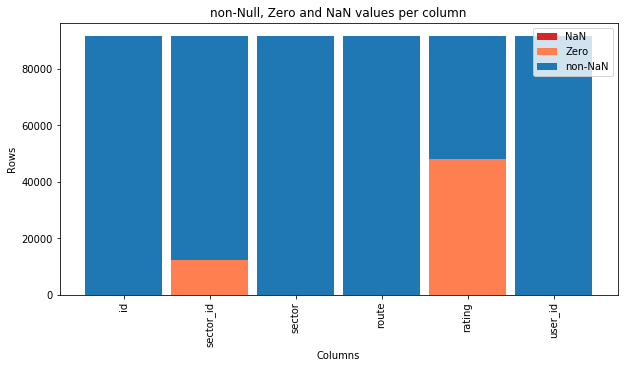

In [16]:
plot_helper.missing_values_overview(X_train)

In our data set `0` is in indicator for missing values, except for `sex` where `0` indicates `male` (and `1` for `female`).

From the graph above we can conclude that we have missing data in `sector_id`, `raw_notes`, `rating`, `height`, `weight`, `birth`, `started_climbing`.

Since `sector_id` and `rating` are important for our analysis, we have to consider what to do about those missing values during Data Preparation later on.

## Analysis of our target variable `rating`

What are the unique values of our target variable?

In [17]:
y_train = X_train['rating']
y_train.unique()

array([2, 0, 3, 1])

And how is their distribution?


In [18]:
percentages = round(y_train.value_counts().sort_index() / y_train.count() * 100, 1)
percentages

0    52.6
1    11.1
2    18.7
3    17.6
Name: rating, dtype: float64

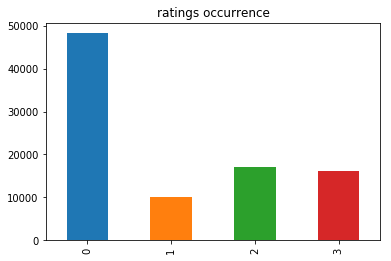

In [19]:
y_train.value_counts().sort_index().plot(
    kind='bar', title='ratings occurrence', xticks=percentages)

In [20]:
y_train[y_train != 0].describe()

count    43483.000000
mean         2.135639
std          0.766220
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: rating, dtype: float64

Out of those climbs, that were rated, the average is 2.14.

What is the percentage of users that rated at least one climb?

In [21]:
(X_train.groupby('user_id')['rating'].sum() == 0).value_counts()

False    2247
True     1055
Name: rating, dtype: int64

This means that approx. 2/3 of users have rated at least one item.

How many ratings are there per user?

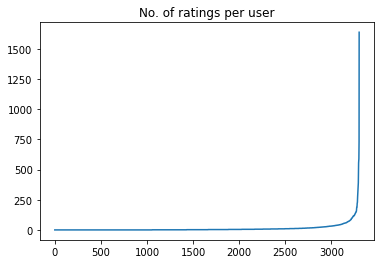

In [22]:
ratings_per_user = X_train.groupby('user_id')['rating'].apply(lambda x: x[x != 0].count())
ratings_per_user.sort_values().plot(
    kind='line', title='No. of ratings per user', use_index=False)

From the above plot we can see that there must be one or several outliers with a large number of ratings (around 1600). Let's apply the logarithm on the y-axis.

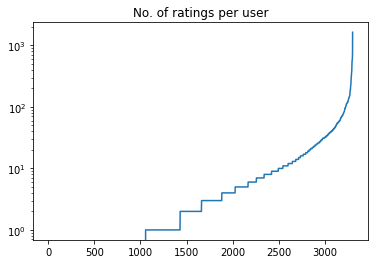

In [23]:
ratings_per_user.sort_values().plot(
    kind='line', title='No. of ratings per user', use_index=False, logy=True)

Now, this has more information. We can see that approx. 30% of users gave no rating at all. And more than 90% of users gave less than 200 ratings.

Let's look at the percentiles information in detail to confirm this.

In [24]:
ratings_per_user.describe(percentiles=[.25, 0.33, .50, .75, .90, .95, .99])

count    3302.000000
mean       13.168686
std        49.493971
min         0.000000
25%         0.000000
33%         1.000000
50%         2.000000
75%         9.000000
90%        29.900000
95%        54.000000
99%       149.000000
max      1639.000000
Name: rating, dtype: float64

## Algorithms and Techniques

## Benchmark

# Methodology

## Data Preprocessing

Remove records from dataset where `sector_id == 0`

In [25]:
X_train = X_train[X_train['sector_id'] != 0]

In [26]:
# TODO
# Consolidate sectors, e.g. sector_id: 839, 12382

### Consolidate route names, remove duplicates

Since our data set does not provide a unique id for routes, we can only go by the name to identify a route. Unfortunately, there are many versions of route names as well as spelling mistakes. In order to arrive at a unique list of routes, we need to do some cleaning up.  

The following example illustrates that.

In [27]:
X_train[X_train['route'].str.startswith('Adr')].drop_duplicates(subset=['route'])['route']

103874      Adrspach weg
43374       Adrspach Weg
86487     Adrschpach Weg
Name: route, dtype: object

Let's start by converting all route names to lowercase and removing special characters.

In [28]:
X_train['route'] = X_train['route'].str.lower()

In [29]:
X_train['route'] = X_train['route'].str.replace('[^A-Za-z\s]+', '')

Remove records with non-alphanumeric entries in columns `sector` or `route`.

In [30]:
import re

def removeNonAlpha(df, columns):
    '''Removes rows from dataframe where value within column is completely non-alphanumeric.
    Ex. '?', '???', '_-%$$'   '''
    
    # regex that matches non alphanumeric strings
    pattern = '^[^a-zA-Z\d\s:]*$'
        
    for col in columns:
        myfilter = df[col].str.contains(pattern)
        df = df[~myfilter]
    
    return df

df = removeNonAlpha(df, ['sector', 'route'])

Get routes per sector

In [31]:
def get_routes_per_sector(df, sector_id):
    '''Returns a series with route names as labels and count of route name occurrences as values'''

    df_one_sector = df[df['sector_id'] == sector_id]
    return df_one_sector['route'].value_counts()

In [32]:
sectors = X_train['sector_id'].drop_duplicates()

In [33]:
# http://www.coli.uni-saarland.de/courses/LT1/2011/slides/Python-Levenshtein.html
# from Levenshtein import distance
from Levenshtein import jaro_winkler

def create_jaro_winkler(keys, prefix_weight=None):
    '''Calculates Jaro-Winkler-Distance among all items of `keys` and returns calculation results as a matrix'''

    # TODO  is there a more pythonic way of calculating this matrix?
    
    jaro_winkler_matrix = np.ones((len(keys), len(keys)))

    i = 0
    while i <= len(keys) - 1:
        j = 0
        while j <= len(keys) - 1:
            if i != j:
                jaro_winkler_matrix[i][j] = jaro_winkler(
                    keys[i], keys[j]) if prefix_weight is None else jaro_winkler(keys[i], keys[j], prefix_weight)
            j += 1
        i += 1

    return jaro_winkler_matrix

In [36]:
def remove_overlap(d):
    '''Resolve 'paths' within the dictionary, e.g. 
     { A : B, B : C }  ->  { A : C, B : C }
     Returns cleaned dictionary'''

    set_keys = set(d.keys())
    set_values = set(d.values())
    set_intersect = set_keys.intersection(set_values)

    for v in set_intersect:
        new_target = d[v]

        filtered_dict = {key: new_target for (
            key, value) in d.items() if value == v}
        filtered_dict

        for i, j in d.items():
            if i in filtered_dict.keys():
                d[i] = filtered_dict[i]

    return d

In [46]:
def clean_routes(df, sector_id, threshold=0.9, prefix_weight=1/1000, debug=False):
    '''Replaces route name within given `sector_id` with the most similar matching name that has the most occurrences.'''

    routes_per_sector = get_routes_per_sector(df, sector_id)
    keys = routes_per_sector.keys()
    values = routes_per_sector.values

    # Create Jaro-Winkler-Matrix and fill diagonal with zeros, 
    # otherwise max value will always be 1.0 (as diagonal is always 1.0)
    jaro_winkler_matrix = create_jaro_winkler(keys, prefix_weight)
    np.fill_diagonal(jaro_winkler_matrix, 0)

    # empty nested dictionary, for replacements of similar route names
    replacements = {'route': {}}

    # find max count of values above threshold
    indices_above_threshold = np.transpose(
        np.nonzero(jaro_winkler_matrix >= threshold))

    first_values = [t[0] for t in indices_above_threshold]
    unique_first_values = np.unique(first_values)

    for u in unique_first_values:
        tuples_list = [t for t in indices_above_threshold if t[0] == u]
        counts_list = [values[t2[1]] for t2 in tuples_list]
        val_max = max(counts_list)
        index_max = counts_list.index(max(counts_list))
        keys[tuples_list[index_max][1]]

        if values[u] < values[tuples_list[index_max][1]]:
            replacements['route'][keys[u]] = keys[tuples_list[index_max][1]]
            if debug:
                print(
                    f'Replacement: {keys[u]}({values[u]}) : {keys[tuples_list[index_max][1]]}({values[tuples_list[index_max][1]]}) ')        

    # Resolve overlaps in replacements
    replacements['route'] = remove_overlap(replacements['route'])
        
    # Replace all found similar route names
    df.loc[df_temp['sector_id'] == sector_id] = df_temp.replace(
        to_replace=replacements)

    return df

In [44]:
# %%pixie_debugger

# df_temp = X_train.copy()
# df_temp = clean_routes(df_temp, 256, debug=True)

In [40]:

# df_temp = clean_routes(X_train, 513)

df_temp = X_train.copy()

for sector in sectors:
    df_temp = clean_routes(df_temp, sector)

111
2020
5169
132
2693
657
348
1333
256
389
1631
126
359
1844
2674
1807
108
156
311
3238
10254
1808
2696
5292
1310
903
492
210
320
234
1309
2860
589
664
1783
1324
3161
624
380
382
10381
2394
2701
522
4990
793
2409
2336
2357
659
1546
650
360
5204
3585
3327
302
10924
1599
4355
706
583
177
2961
369
625
12229
3438
1687
4646
715
2082
800
687
4545
5567
608
304
911
3087
10204
4455
457
12224
4677
97
2415
580
1580
1314
10723
6990
6994
238
1315
1327
3193
3675
1773
513
587
2638
2269
452
1323
2119
3185
1901
5382
833
758
13027
2547
2340
2874
6139
3577
2666
12178
184
4858
3180
1824
1544
2751
481
459
839
5558
1677
909
421
2141
5797
700
4507
5692
2798
381
5404
4943
422
11312
6443
10352
6036
3630
6610
637
1524
2697
593
2517
2356
8810
2571
1282
766
9162
915
6441
1660
1831
2984
611
2302
1326
525
13017
8129
647
5526
5701
2341
5340
12751
3219
2712
3050
616
3267
2046
8469
5527
8550
2388
5232
4227
4697
4784
1638
8281
2661
4843
2271
2428
12451
2337
3337
2529
5272
1312
10975
10160
2433
10289
8404
2283
5358
167

In [51]:
df_temp[df_temp['route'].str.startswith('kal')]

,id,sector_id,sector,route,rating,user_id
65057,3282474,513,Kalte Wand,kalter knig,3,32640
55490,2888614,4784,Loreley,kalypso,0,18527
21985,1348863,2341,Schiefer Tod,kalter hauch,1,18348
102510,4523255,513,Kalte Wand,kalte schorle,1,20095
58986,2988245,647,Obere Gößweinsteiner Wände,kalauer,0,42769
48542,2559522,513,Kalte Wand,kalter knig,0,12478
31344,1774973,4784,Loreley,kalypso,3,23550
111406,4852305,513,Kalte Wand,kalter knig,1,34917
112935,4881134,3481,Eibenwände,kalte zeiten,0,50735
36484,2052662,647,Obere Gößweinsteiner Wände,kalauer,2,15312


limit_output extension: Maximum message size of 10000 exceeded with 11246 characters

Extract all the individual routes

In [42]:
X_train_routes = X_train[['sector_id', 'sector', 'route']].drop_duplicates()
X_train_routes.head(10)

,sector_id,sector,route
94682,111,Marientaler Wände,geisterbahn
44736,111,Marientaler Wände,left side of darkness
9203,2020,Graischer Bleisteinwande,anne sofi
106174,5169,Jungfernriss,schotterweg
84724,132,Diebesloch,quergang
11722,2693,Rodenstein,malmriss
43458,657,Zehnerstein,westschleife
82309,348,Rote Wand,direkter gipfelstrmer
22057,1333,Mader Ged.-Wand,stalingrad
35729,256,Krottenseer Turm,westwand


In [43]:
X_train_routes.reset_index(inplace=True, drop=True)
# X_train_routes = X_train_routes.drop(columns=['index'])
X_train_routes.head(10)

,sector_id,sector,route
0,111,Marientaler Wände,geisterbahn
1,111,Marientaler Wände,left side of darkness
2,2020,Graischer Bleisteinwande,anne sofi
3,5169,Jungfernriss,schotterweg
4,132,Diebesloch,quergang
5,2693,Rodenstein,malmriss
6,657,Zehnerstein,westschleife
7,348,Rote Wand,direkter gipfelstrmer
8,1333,Mader Ged.-Wand,stalingrad
9,256,Krottenseer Turm,westwand


## Implementation

## Refinement

# Results

## Model Evaluation and Validation

## Justification

# Conclusion

## Free-Form Visualization

## Reflection

## Improvement